<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных" data-toc-modified-id="Изучение-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных</a></span></li><li><span><a href="#Исследовательский-анализ,-подготовка-данных" data-toc-modified-id="Исследовательский-анализ,-подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ, подготовка данных</a></span></li><li><span><a href="#Разделение-на-выборки-для-обучения" data-toc-modified-id="Разделение-на-выборки-для-обучения-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Разделение на выборки для обучения</a></span></li><li><span><a href="#Обучение,-валидация" data-toc-modified-id="Обучение,-валидация-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение, валидация</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Дерево решений</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Тестирование моделей</a></span></li><li><span><a href="#Проверка-на-вменяемость" data-toc-modified-id="Проверка-на-вменяемость-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Проверка на вменяемость</a></span></li></ul></div>

# Переход на новый тарифный план

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами.

**Цель**: проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф, с максимально большим значением *accuracy* (0.75 или больше). Проверим *accuracy* на тестовой выборке.

## Изучение данных

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
from random import seed
from random import random
import statistics

In [2]:
#warnings.simplefilter("once")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
pth1 = '/datasets/users_behavior.csv'
pth2 = 'users_behavior.csv'
if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


В таблице 5 столбцов, 3214 строк. Пропусков данных нет. Предобработка и исследовательский анализ данных не требуются, т.к. были сделаны в ранее другом проекте.

* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца (***«Ультра» — 1, «Смарт» — 0***).

## Исследовательский анализ, подготовка данных

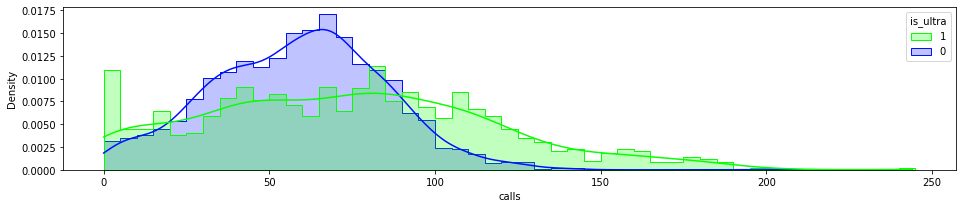

In [5]:
fig, ax = plt.subplots(figsize=(16,3))
sns.histplot(df, x='calls', hue='is_ultra', hue_order=[1,0]
             , stat='density', kde=True, element='step', binwidth=5
             , common_norm=False, log_scale=False, palette='hsv', fill=True, ax=ax)
plt.show();

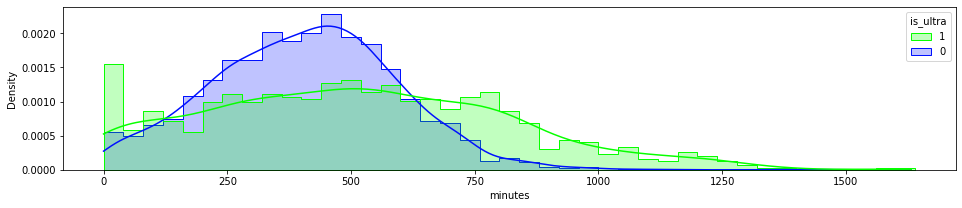

In [6]:
fig, ax = plt.subplots(figsize=(16,3))
sns.histplot(df, x='minutes', hue='is_ultra', hue_order=[1,0]
             , stat='density', kde=True, element='step', binwidth=40
             , common_norm=False, log_scale=False, palette='hsv', fill=True, ax=ax)
plt.show();

Можно заметить, что рисунки распределения кол-ва звонков и общей длительности разговоров очень похожи.

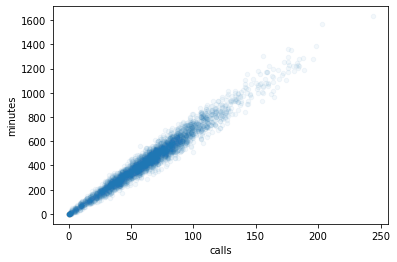

In [23]:
df.plot(kind='scatter', x='calls', y='minutes', alpha=0.05);

Видна чёткая линейная зависимость. Проверим корреляцию:

In [7]:
print('Коэф-т корреляции Пирсона:', df['calls'].corr(df['minutes']))

Коэф-т корреляции Пирсона: 0.9820832355742294


Очень высокий показатель. Поскольку у этих 2 переменных такая сильная зависимость, для обучения моделей лучше оставить одну из них, пусть это будет длительность разговоров. Столбец `calls` добавлять в признаки не будем.

## Разделение на выборки для обучения
Разобьём выборку на признаки, целевой признак, а также на тренировочную, валидационную и тестовую выборки в соотношении 90/5/5.
<br>В нашем случае целевой признак - это `is_ultra`. А задача - бинарная классификация, т.к. тарифов всего 2.

In [8]:
features = df.drop(columns=['is_ultra', 'calls'])
target = df['is_ultra']

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, 
    train_size=0.9, shuffle=True, random_state=12345
)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, 
    test_size=0.5, shuffle=True, random_state=12345
)

print(len(features_train))
print(len(features_valid))
print(len(features_test))
display(features_train.head(1))
display(features_valid.head(1))
display(features_test.head(1))

2892
161
161


,minutes,messages,mb_used
1783,269.32,14.0,15471.54


,minutes,messages,mb_used
2932,636.52,6.0,15190.74


,minutes,messages,mb_used
2858,590.3,20.0,25837.4


## Обучение, валидация 

Обучим изученные в спринте модели: дерево решений, случайный лес, логистическую регрессию - и с помощью валидационных выборок подберем гиперпараметры для первых двух из них.

Также попробуем применить рекомендацию из Slack от одного из ревьюеров:
<br>Есть честный способ повысить точность модели путем увеличения размера выборки. На этапе тестирования валидационная выборка уже выполнила свою задачу - мы подобрали гиперпарамеры. Теперь мы можем обучить нашу модель на увеличенном наборе данных (валидация + обучение) и протестировать на тестовом наборе.
<br>Для этого заранее подготовим увеличенные тренировочные выборки:

In [9]:
features_train_2 = pd.concat([features_train, features_valid], ignore_index=True)
target_train_2 = pd.concat([target_train, target_valid], ignore_index=True)
print(features_train_2.shape, target_train_2.shape)

(3053, 3) (3053,)


### Дерево решений

In [10]:
best_tree_model = None
best_accuracy = 0
best_tree_depth = 0

for max_depth in range(1,21):
    model = DecisionTreeClassifier(random_state=123, max_depth=max_depth)
    model.fit(features_train, target_train)
    accuracy = model.score(X=features_valid, y=target_valid) 
    #print('max_depth =', max_depth, ':', accuracy)
    if (accuracy > best_accuracy):
        best_accuracy = accuracy
        best_tree_model = model
        best_tree_depth = max_depth
        
print('Best decision tree: depth=', best_tree_depth, ', accuracy=', best_accuracy, sep='')

Best decision tree: depth=5, accuracy=0.782608695652174


*Accuracy* достаточное (по условиям задания), хоть и не слишком большое.
<br>Переобучим дерево с полученной лучшей глубиной на увеличенной выборке:

In [11]:
tree_model = DecisionTreeClassifier(random_state=123, max_depth=best_tree_depth)
tree_model.fit(features_train_2, target_train_2);

DecisionTreeClassifier(max_depth=5, random_state=123)

### Случайный лес

In [12]:
best_forest_model = None
best_accuracy = 0
best_forst_depth = 0
best_forest_n = 0

for est in range(6, 51, 2):
    for depth in range (3, 21):
        model = RandomForestClassifier(random_state=123456, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        accuracy = model.score(features_valid, target_valid)
        #print(est, depth, accuracy)
        if accuracy > best_accuracy:
            best_forest_model = model
            best_accuracy = accuracy
            best_forest_depth = depth
            best_forest_n = est

print('Best random forest: depth=', best_forest_depth, ', n_estimators=', best_forest_n, ', accuracy=', best_accuracy, sep='')

Best random forest: depth=15, n_estimators=8, accuracy=0.8012422360248447


*Accuracy* немного выше, чем у дерева решений.
<br>Переобучим лес с лучшими гиперпараметрами на увеличенной выборке:

In [13]:
forest_model = RandomForestClassifier(random_state=123456, n_estimators=best_forest_n, max_depth=best_forest_depth)
forest_model.fit(features_train_2, target_train_2);

### Логистическая регрессия

Логистическую регрессию сразу обучим на увеличенной выборке, т.к. гиперпараметры для неё подбирать не нужно:

In [14]:
log_regression_model = LogisticRegression(random_state=12345)
log_regression_model.fit(features_train_2, target_train_2);

## Тестирование моделей

In [15]:
accuracy = best_tree_model.score(features_test, target_test)
print('Decision tree: depth=', best_tree_depth, ', accuracy=', accuracy, sep='')

accuracy = forest_model.score(features_test, target_test)
print('Random forest: depth=', best_forest_depth, ', n_estimators=', best_forest_n, ', accuracy=', accuracy, sep='')

accuracy = log_regression_model.score(features_test, target_test)
print('Logistic regression: accuracy=', accuracy, sep='')

Decision tree: depth=5, accuracy=0.7950310559006211
Random forest: depth=15, n_estimators=8, accuracy=0.8322981366459627
Logistic regression: accuracy=0.7639751552795031


Значение *accuracy* всех 3 моделей выше 0.75, но отличных результатов добиться не удалось. Возможно, потому что это самые простые модели.
<br>Ожидаемо, самое высокое значение получилось у случайного леса.

## Проверка на вменяемость

Для проверки полученных выше моделей на вменяемость создадим выборку с целевым признаком, рассчитанным случайной "моделью", и посчитаем *accuracy*.

In [16]:
tariff_mean = df['is_ultra'].mean()
tariff_mean

0.30647168637212197

In [17]:
seed(549)
sanity_check = [1 if random() < tariff_mean else 0   for x in range(len(target_test))]
print(sanity_check[0:10], ', length:', len(sanity_check))
statistics.mean(sanity_check)

[0, 1, 1, 0, 0, 1, 0, 0, 0, 0] , length: 161


0.2981366459627329

In [18]:
accuracy_score(target_test, sanity_check)

0.5652173913043478

Для псевдослучайных чисел получили *accuracy*=0.565, заметно меньше, чем для моделей выше, так что можно сказать, что обученные модели **вменяемы**.

In [21]:
dt.datetime.today().strftime("%d.%m.%Y %H:%M")

'19.04.2022 16:56'